In [59]:
import pandas as pd 
import sqlalchemy as db
from sqlalchemy import create_engine
from sqlalchemy import join
from sqlalchemy.sql import select

#  Flow 
1. Create an engine object that connects to database. Passing database path through. 
2. Call .connect() method on object 
3. Instantiate MetaData() object
4. Explore Database columns, and tables 
4. Connect to specific Table in data base with Table Method 
5. Write/Run queries 

## Start

In [60]:
# instantiating connection and metadata objects 
engine = create_engine('sqlite:///sqlite-sakila.db')
cnx = engine.connect()
metadata = db.MetaData()



## Exploring Database structure

In [61]:
# finding table names 
table_names = engine.table_names()
print(table_names)

# find the column names for all tables 

def connect_to_table(cnx):
    tables = []
    
    for table in table_names:
        tbl = db.Table(table,metadata,autoload=True,autoload_with=cnx)
        tables.append(tbl)
    return tables 

_tables = connect_to_table(cnx)


['actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'film_text', 'inventory', 'language', 'payment', 'rental', 'staff', 'store']


In [62]:
def get_column_names(_tables,table_names):
    table_columns = {}
    i = 0
    for tbl in _tables:
        table_columns[table_names[i]] = [c.name for c in tbl.columns]
        i += 1
    return table_columns 

TN_CN = get_column_names(_tables,table_names)
TN_CN['film']

['film_id',
 'title',
 'description',
 'release_year',
 'language_id',
 'original_language_id',
 'rental_duration',
 'rental_rate',
 'length',
 'replacement_cost',
 'rating',
 'special_features',
 'last_update']

## The SELECT Statement 
*We actually connected to all the tables in the function connect_to_table, but lets rename them becasue right now they are stored as a list of table objects.*

1. Lets show the title and description of a film from the table 'film' 

In [63]:
# lets use the 'film' table to run our first query 
# renaming object so we dont have to reference it by list index 

film = _tables[6]

SELECT_query = db.select([film.columns['title'],film.columns['description'],film.columns['length'],film.columns['rating']])
ResultProxy = cnx.execute(SELECT_query)
ResultSet = ResultProxy.fetchall()

#showing results in a dataframe 
select_ = pd.DataFrame(ResultSet, columns = ['TITLE','DESCRIPTION','MOVIE LENGTH','RATING'])
select_.head()

,TITLE,DESCRIPTION,MOVIE LENGTH,RATING
0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,PG
1,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,48,G
2,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,50,NC-17
3,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,117,G
4,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,130,G


## The SELECT Statement with LIKE
Lets augment the above query 'SELECT_query' and filter with LIKE and WHERE

In this query we want to see all titles films that have Dinosaur in the title. Maybe our kid really loves dinosours. 

In [64]:
SELECT_LIKE_query = SELECT_query.where(film.columns['title'].like("%Dinosaur%"))
ResultProxy = cnx.execute(SELECT_LIKE_query)
ResultSet = ResultProxy.fetchall()

select_like = pd.DataFrame(ResultSet, columns = ['TITLE','DESCRIPTION','MOVIE LENGTH','RATING'])
select_like.head()

,TITLE,DESCRIPTION,MOVIE LENGTH,RATING
0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,PG
1,CENTER DINOSAUR,A Beautiful Character Study of a Sumo Wrestler...,152,PG
2,DINOSAUR SECRETARY,A Action-Packed Drama of a Feminist And a Girl...,63,R


## The AND statement
Ok we were able to find all films that have dinasour in the title, but as you can see above one of the films returned a rated R rating. So lets see if we can Now expand our query to show only pg films that have a run time less than 90mins


In [65]:
#writing/executing query
SELECT_LIKE_AND_query = SELECT_query.where(db.and_(film.columns['title'].like('%Dinosaur%'),film.columns['rating'] == 'PG',film.columns['length']<=90))
ResultProxy = cnx.execute(SELECT_LIKE_AND_query)
ResultSet = ResultProxy.fetchall()

# results in dataframe
select_like_and = pd.DataFrame(ResultSet, columns = ['TITLE','DESCRIPTION','MOVIE LENGTH','RATING'])

print('Movie Description: ',select_like_and['DESCRIPTION'][0])
select_like_and

Movie Description:  A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies


,TITLE,DESCRIPTION,MOVIE LENGTH,RATING
0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,86,PG


## GROUP BY and COUNT
Letes use group by to look at the distributing of rating type that this store offers, to see if there are enough PG titles to justify shopping here.

We also need to import 'func' from the sqlalchemy library

In [66]:
from sqlalchemy import func
#importing seaborn library for plotting results
import seaborn as sns

select_ = db.select([film.columns['rating'],func.count(film.columns['rating']).label('RATING')])
select_group_by = select_.group_by(film.columns['rating']).order_by(db.desc('RATING'))

ResultProxy = cnx.execute(select_group_by)
ResultSet = ResultProxy.fetchall()

ratings_distribution = pd.DataFrame(ResultSet, columns = ['Rating Type','Num Per Rating'])
ratings_distribution

,Rating Type,Num Per Rating
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


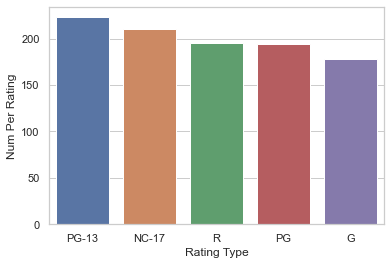

In [67]:
ax = sns.barplot( x = 'Rating Type',y='Num Per Rating',data=ratings_distribution)

## The JOIN operation 
Finally lets flex our muscles with SQL alchemy a little bit and see if we can use the join statement to settle a customer dispute. A customer, call her Charlotte is disputing an accusation that she didn't return a film she rented. The clerk currently on shift was not at the store when she claimed to have returned the film. So we need to track down the customer name, the rental date, the claimed return date, the employee on shift at the time and the film title. Lets see if we can do this with SQL Alchemy,

In [68]:
from sqlalchemy import join 
from sqlalchemy.sql import select

rental = _tables[13]
inventory = _tables[10]
customer = _tables[5]

join_a = rental.join(inventory,rental.c.inventory_id==inventory.c.inventory_id)
join_b = join_a.join(customer, customer.c.customer_id==rental.c.customer_id)


select_statement = select([customer.c.first_name,rental.c.customer_id,
                    rental.c.rental_date,rental.c.return_date,rental.c.staff_id,
                         inventory.c.inventory_id]).select_from(join_b)
query = select_statement.where(customer.c.first_name == 'CHARLOTTE')



ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

customer_dispute = pd.DataFrame(ResultSet, columns = ['Name','Rental_Date','Return_Date','Customer ID','Staff ID','Film ID'])
customer_dispute.head()

,Name,Rental_Date,Return_Date,Customer ID,Staff ID,Film ID
0,CHARLOTTE,130,2005-05-24 22:53:30,2005-05-26 22:04:30,1,367
1,CHARLOTTE,130,2005-05-29 09:25:10,2005-06-02 04:20:10,2,4272
2,CHARLOTTE,130,2005-06-16 07:55:01,2005-06-19 06:38:01,1,2413
3,CHARLOTTE,130,2005-06-17 01:39:47,2005-06-24 19:39:47,2,1815
4,CHARLOTTE,130,2005-06-17 23:46:16,2005-06-22 22:48:16,2,2600


# Top Customer 

In [69]:
JOIN = rental.join(customer, rental.c.customer_id==customer.c.customer_id)

select_ = select([rental.c.customer_id,customer.c.first_name,customer.c.last_name,func.count(rental.c.rental_date).label("NumRentals")])
select_join = select_.select_from(JOIN)
query = select_join.group_by(rental.c.customer_id).order_by(db.desc('NumRentals'))

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

top_customers = pd.DataFrame(ResultSet, columns = ['CustomerID','FirstName','LastName','NumRentals'])
top_customers

,CustomerID,FirstName,LastName,NumRentals
0,148,ELEANOR,HUNT,46
1,526,KARL,SEAL,45
2,144,CLARA,SHAW,42
3,236,MARCIA,DEAN,42
4,75,TAMMY,SANDERS,41
...,...,...,...,...
594,248,CAROLINE,BOWMAN,15
595,61,KATHERINE,RIVERA,14
596,110,TIFFANY,JORDAN,14
597,281,LEONA,OBRIEN,14


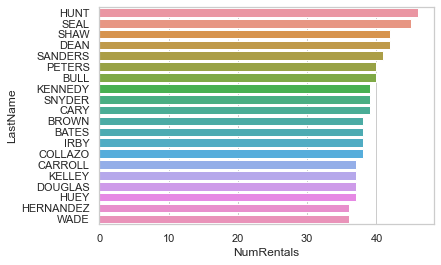

In [70]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(x="NumRentals", y="LastName", data=top_customers[:20])


# Top customer film type distribution 

In [71]:
JOIN_A = rental.join(inventory,rental.c.inventory_id==inventory.c.inventory_id)
JOIN_B = JOIN_A.join(film, inventory.c.film_id==film.c.film_id)

SELECT = select([film.c.rating,func.count(film.c.rating).label('RatingCount')])
collect_joins = SELECT.select_from(JOIN_B)

query = collect_joins.group_by(film.c.rating).order_by(db.desc('RatingCount'))

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

top_customer_film_types = pd.DataFrame(ResultSet, columns = ['Rating','RatingCount'])
top_customer_film_types

,Rating,RatingCount
0,PG-13,3585
1,NC-17,3293
2,PG,3212
3,R,3181
4,G,2773


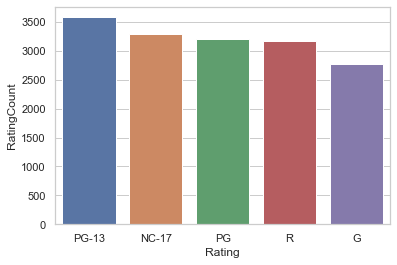

In [72]:
ax = sns.barplot(x="Rating", y="RatingCount", data=top_customer_film_types)


In [73]:
join_A = rental.join(customer, rental.c.customer_id==customer.c.customer_id)
join_B = join_A.join(inventory, rental.c.inventory_id==inventory.c.inventory_id)
join_C = join_B.join(film , inventory.c.film_id==film.c.film_id)

SELECT = select([customer.c.customer_id,func.count(rental.c.rental_date).label('NumRentals')])
join_select = SELECT.select_from(join_C)
query = join_select.where(customer.c.active==0).group_by(rental.c.customer_id).order_by(db.desc('NumRentals'))

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

top_inactive_customers = pd.DataFrame(ResultSet, columns = ['CustomerID','NumRentals'])
top_inactive_customers


,CustomerID,NumRentals
0,368,35
1,241,34
2,64,33
3,406,32
4,446,31
5,482,29
6,592,29
7,16,28
8,558,28
9,510,26


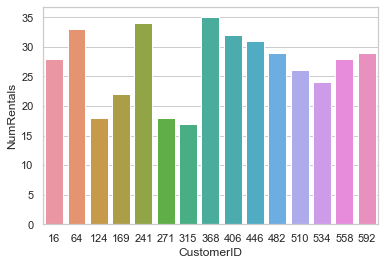

In [74]:
ax2 = sns.barplot(x="CustomerID", y="NumRentals", data=top_inactive_customers)


In [75]:
join_A = rental.join(customer, rental.c.customer_id==customer.c.customer_id)
join_B = join_A.join(inventory, rental.c.inventory_id==inventory.c.inventory_id)
join_C = join_B.join(film , inventory.c.film_id==film.c.film_id)

_select_ = select([film.c.rating,func.count(film.c.rating).label('CountRatings')])
join_select = _select_.select_from(join_C)
query = join_select.where(customer.c.customer_id==368).group_by(film.c.rating).order_by(db.desc('CountRatings'))

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

ratings_distribution = pd.DataFrame(ResultSet, columns = ['Rating','CountRatings'])
ratings_distribution

,Rating,CountRatings
0,PG-13,9
1,PG,8
2,NC-17,8
3,G,7
4,R,3


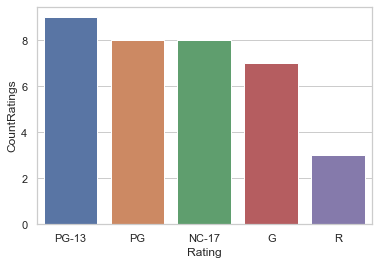

In [76]:
ax3 = sns.barplot(x="Rating", y="CountRatings", data=ratings_distribution)


In [77]:
SELECT = select([rental.c.customer_id,film.c.rating,film.c.description,film.c.film_id])
SELECT_JOIN = SELECT.select_from(join_C)

query = SELECT_JOIN.where(db.and_(rental.c.customer_id==368,film.c.rating == 'PG-13'))

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

harrys_pg13 = pd.DataFrame(ResultSet, columns = ['CustomerID','Rating','Description','FilmID'])
harrys_pg13

,CustomerID,Rating,Description,FilmID
0,368,PG-13,A Stunning Drama of a Teacher And a Boat who m...,690
1,368,PG-13,A Amazing Drama of a Car And a Squirrel who mu...,504
2,368,PG-13,A Amazing Drama of a Car And a Squirrel who mu...,504
3,368,PG-13,A Amazing Tale of a Crocodile And a Squirrel w...,219
4,368,PG-13,A Touching Yarn of a Frisbee And a Dentist who...,439
5,368,PG-13,A Thoughtful Display of a Astronaut And a Femi...,596
6,368,PG-13,A Unbelieveable Display of a Crocodile And a F...,922
7,368,PG-13,A Touching Saga of a Robot And a Boy who must ...,389
8,368,PG-13,A Intrepid Yarn of a Explorer And a Pastry Che...,921


In [88]:
base_query = select([film.c.film_id,film.c.rating,film.c.title,film.c.description])
query = base_query.where(db.and_(film.c.rating=='PG-13',film.c.description.like('%drama%'),film.c.description.like('%feminist%')))

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

harrys_new = pd.DataFrame(ResultSet, columns = ['FilmID','Rating','Title','Description'])
harrys_new

,FilmID,Rating,Title,Description
0,18,PG-13,ALTER VICTORY,A Thoughtful Drama of a Composer And a Feminis...
1,690,PG-13,POND SEATTLE,A Stunning Drama of a Teacher And a Boat who m...
2,712,PG-13,RAIDERS ANTITRUST,A Amazing Drama of a Teacher And a Feminist wh...


# Time Series Analysis


In [91]:
base_query = select([func.strftime('%H',rental.c.return_date).label('HR'),func.count(rental.c.customer_id)])
query = base_query.group_by('HR')
ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

rental_dates = pd.DataFrame(ResultSet, columns = ['HR','FPH'])
rental_dates


,HR,FPH
0,None,183
1,00,706
2,01,668
3,02,649
4,03,644
5,04,677
6,05,683
7,06,676
8,07,685
9,08,641


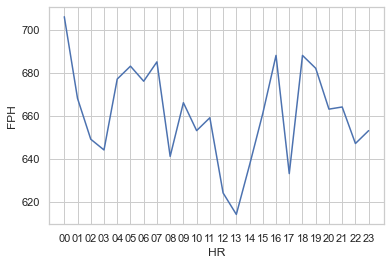

In [93]:
ax = sns.lineplot(x='HR',y='FPH',data=rental_dates[1:])

# Top 10 customer shoppin patterns 


In [187]:
customer_ids = [148,526,144,236,75,197,469,137,178,468]

def get_top_10(customer_ids):
    customer_plots = []
    for i in range(len(customer_id)):
        base_query = select([func.strftime('%H',rental.c.rental_date).label('HR'),func.count(rental.c.customer_id)])
        query = base_query.where(rental.c.customer_id == customer_id[i]).group_by('HR')

        ResultProxy = cnx.execute(query)
        ResultSet = ResultProxy.fetchall()
    
        customer_plot = pd.DataFrame(ResultSet, columns = ['HR','FPH{}'.format(customer_id[i])])
        customer_plots.append(customer_plot)
    
    return customer_plots

plots = get_top_10(customer_ids)

def get_top_10_average(customer_ids):
    base_query = select([func.strftime('%H',rental.c.rental_date).label('HR'),func.count(rental.c.customer_id)])
    query = base_query.where(rental.c.customer_id.in_(customer_ids)).group_by('HR')
    
    ResultProxy = cnx.execute(query)
    ResultSet = ResultProxy.fetchall()
    
    top_10_count = pd.DataFrame(ResultSet,columns= ['HR','FPH'])
    return top_10_count

top_10_count = get_top_10_average(customer_ids)
#top_10_count


    
    
    

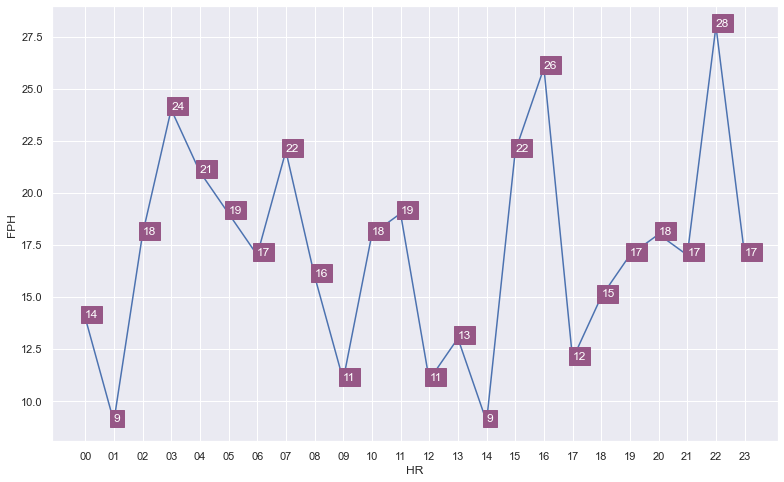

In [202]:
import matplotlib.pyplot as plt

ax = sns.lineplot(x='HR',y='FPH', data= top_10_count,marker='*')
for x,y in zip(top_10_count['HR'],top_10_count['FPH']):
  
    plt.text(x=x,y=y,s='{:.0f}'.format(y),color='white').set_backgroundcolor('#965786')

# More fun with timestamps

In [211]:
base_query = select([func.strftime('%Y-%m-%d',rental.c.rental_date),func.strftime('%H',rental.c.rental_date).label('H'),func.count(rental.c.customer_id)])
query = base_query.where(db.and_(func.strftime('%Y',rental.c.rental_date)== '2005',func.strftime('%m',rental.c.rental_date)=='08')).group_by(func.strftime('%d',rental.c.rental_date),'H')

ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

august = pd.DataFrame(ResultSet,columns = ['Day','Hour','CPH'])



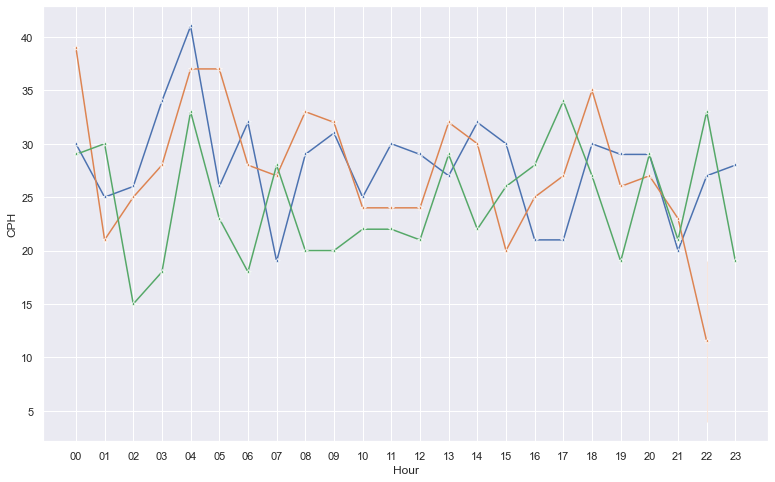

In [230]:
ax = sns.lineplot(x='Hour',y='CPH', data= august[:24],marker='*')
ax = sns.lineplot(x= 'Hour',y='CPH', data= august[24:48],marker = '*')
ax = sns.lineplot(x= 'Hour',y='CPH', data= august[48:72],marker = '*')
#ax = sns.lineplot(x='Hour',y='CPH', data=august[72:96],marker = '*')
#ax = sns.lineplot(x='Hour',y='CPH', data=august[96:120],marker = '*')
#ax = sns.lineplot(x='Hour',y='CPH', data=august[120:144],marker = '*')



In [235]:
# defining payment table
payment =_tables[12]
#payment

Table('payment', MetaData(bind=None), Column('payment_id', INTEGER(), table=<payment>, primary_key=True, nullable=False), Column('customer_id', INTEGER(), ForeignKey('customer.customer_id'), table=<payment>, nullable=False), Column('staff_id', SMALLINT(), ForeignKey('staff.staff_id'), table=<payment>, nullable=False), Column('rental_id', INTEGER(), ForeignKey('rental.rental_id'), table=<payment>, server_default=DefaultClause(<sqlalchemy.sql.elements.TextClause object at 0x16656fc70>, for_update=False)), Column('amount', DECIMAL(precision=5, scale=2), table=<payment>, nullable=False), Column('payment_date', TIMESTAMP(), table=<payment>, nullable=False), Column('last_update', TIMESTAMP(), table=<payment>, nullable=False), schema=None)

In [236]:
query = select([film.c.title, film.c.description,film.c.rating])
ResultProxy = cnx.execute(query)
ResultSet = ResultProxy.fetchall()

film_descriptions = pd.DataFrame(ResultSet,columns = ['Title','Description','Rating'])
film_descriptions.head()

,Title,Description,Rating
0,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,PG
1,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,G
2,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,NC-17
3,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,G
4,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,G


In [84]:
film_descriptions['Description'][2]

'A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory'